In [23]:
import matplotlib
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import lxml

In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

In [2]:

# Set your postgres username
dbname = 'congressional_bills'
username = 'melissaferrari' # change this to your username

In [3]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://melissaferrari@localhost/congressional_bills


In [4]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [14]:
con.rollback()

Try a few other sample queries.  Before you type in each one, ask yourself what you think the output will look like:
`SELECT * FROM birth_data_table;`


`SELECT * FROM birth_data_table WHERE infant_sex='M';`

`SELECT COUNT(infant_sex) FROM birth_data_table WHERE infant_sex='M';`

`SELECT COUNT(gestation_weeks), infant_sex FROM birth_data_table WHERE infant_sex = 'M' GROUP BY gestation_weeks, infant_sex;`

`SELECT gestation_weeks, COUNT(gestation_weeks) FROM birth_data_table WHERE infant_sex = 'M' GROUP BY gestation_weeks;`

All the above queries run, but they are difficult to visually inspect in the Postgres terminal.

In [6]:
cur = con.cursor()

In [12]:
query = """
        SELECT DISTINCT bv.code, bv.title FROM bill_text bt 
        INNER JOIN bill_versions bv ON bt.bill_version_id = bv.id;
        """

In [15]:
cur.execute(query)

In [17]:
cur.fetchall()

[('ES', 'Engrossed (Senate)'),
 ('IH', 'Introduced (House)'),
 ('ENR', 'Enrolled'),
 ('RS', 'Reported in (Senate)'),
 ('EAH', 'Engrossed Amendment (House)'),
 ('EH', 'Engrossed (House)'),
 ('IS', 'Introduced (Senate)'),
 ('RH', 'Reported in (House)'),
 ('PCS', 'Placed on Calendar (Senate)')]

### Get distribution of topics.

In [214]:
query = """
        SELECT subjects_top_term, COUNT(*) FROM bills GROUP BY subjects_top_term;
        """

In [47]:
cur.execute(query)
cur.fetchmany(5)

[('Arts, culture, religion', 60),
 ('Labor and employment', 817),
 ('Sports and recreation', 46),
 ('Science, technology, communications', 673),
 ('Emergency management', 440)]

In [215]:
top_subjects = pd.read_sql_query(query, engine).set_index('subjects_top_term').sort_values(by='count', ascending=False)
top_subjects.head(7)

,count
subjects_top_term,
Health,3490
Taxation,2915
Armed forces and national security,2741
Government operations and politics,2233
Public lands and natural resources,1876
Crime and law enforcement,1810
Education,1520


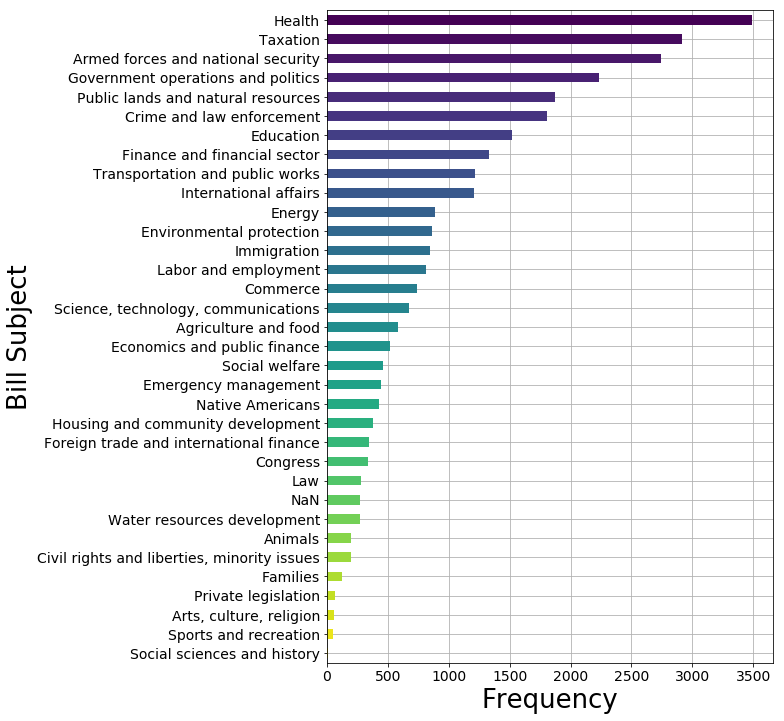

In [66]:
fig, ax = plt.subplots(figsize=(8, 12))
colors = matplotlib.cm.viridis_r(np.linspace(0, 1, len(top_subjects)))
top_subjects['count'].sort_values().plot(kind='barh', ax=ax, stacked=True, color=colors);
ax.grid(); ax.set_axisbelow(True); ax.set_ylabel('Bill Subject', size=26); ax.set_xlabel('Frequency', size=26);

In [67]:
top_subjects.describe()

,count
count,34.000000
mean,887.500000
std,888.054778
min,11.000000
25%,275.500000
50%,550.500000
75%,1214.000000
max,3490.000000


In [87]:
top25 = top_subjects.nlargest(int(0.25*len(top_subjects)), 'count')
top25

,count
subjects_top_term,
Health,3490
Taxation,2915
Armed forces and national security,2741
Government operations and politics,2233
Public lands and natural resources,1876
Crime and law enforcement,1810
Education,1520
Finance and financial sector,1329


In [92]:
list(top25.index.values)

['Health',
 'Taxation',
 'Armed forces and national security',
 'Government operations and politics',
 'Public lands and natural resources',
 'Crime and law enforcement',
 'Education',
 'Finance and financial sector']

In [167]:
summary_table = pd.read_sql_table('summaries', con=engine, columns=None)#, index_col='id')
summary_table.head()

,id,bill_ix,as,date,text,source
0,9677,7899,Introduced in House,2016-07-13,Marine Mammal Research and Response Act of 201...,1
1,9678,7900,Introduced in House,2015-05-21,Coastal Communities Ocean Acidification Act of...,1
2,9679,7901,Introduced in House,2015-09-10,"Police Reporting Information, Data, and Eviden...",1
3,9680,7902,Introduced in House,2015-06-12,Sanctity of Life Act of 2015\n\nDeclares that:...,1
4,9681,7903,Introduced in House,2016-02-08,Funding Unpaid National Debt with Settlements ...,1


In [168]:
print('There are {} summaries'.format(len(summary_table)))

There are 23812 summaries


In [169]:
bills_info = pd.read_sql_table('bills', con=engine)
bills_info.head(3)

,id,official_title,popular_title,url,bill_type,status_at,by_request,sponsor,updated_at,status,number,subjects_top_term,bill_id,introduced_at,congress,short_title
0,5529,To require the Securities and Exchange Commiss...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-03-03,False,153,2017-12-11 19:28:52,4.0,1216,Finance and financial sector,hr1216-114,2015-03-03,114,Maker-Taker Conflict of Interest Reform Act of...
1,5530,To direct the Secretary of Veterans Affairs to...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2016-03-16,False,12419,2017-12-11 21:02:18,4.0,4764,Armed forces and national security,hr4764-114,2016-03-16,114,Puppies Assisting Wounded Servicemembers (PAWS...
2,5531,To provide limitations on maritime liens on fi...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-01-13,False,256,2017-12-11 19:10:21,4.0,337,Transportation and public works,hr337-114,2015-01-13,114,Maritime Lien Reform Act


In [170]:
bills_text_table = pd.read_sql_table('bill_text', con=engine, columns=None)#, index_col='id')

In [175]:
summary_table.columns

Index(['id', 'bill_ix', 'as', 'date', 'text', 'source'], dtype='object')

In [177]:
bills_text_table.columns

Index(['bill_ix', 'bill_version_id', 'text'], dtype='object')

In [180]:
bills_info.columns

Index(['id', 'official_title', 'popular_title', 'url', 'bill_type',
       'status_at', 'by_request', 'sponsor', 'updated_at', 'status', 'number',
       'subjects_top_term', 'bill_id', 'introduced_at', 'congress',
       'short_title'],
      dtype='object')

In [284]:
query = """
        SELECT 
        sm.text AS summary_text,
        sm.bill_ix, sm.as, sm.date,
        bv.code,
        bt.text AS full_text
        FROM summaries sm
        INNER JOIN bill_text bt
        ON sm.bill_ix=bt.bill_ix
        INNER JOIN bill_versions bv
        ON bv.id=bt.bill_version_id
        ;
        """
bill_inner_join = pd.read_sql_query(query, engine)

In [285]:
bill_inner_join.full_text.nunique()

30669

In [286]:
bill_inner_join.summary_text.nunique()

21736

In [287]:
bill_inner_join.summary_text.nunique()

21736

In [288]:
bill_inner_join.head()

,summary_text,bill_ix,as,date,code,full_text
0,Consumer Financial Protection Commission Act o...,27059,Introduced in House,2013-06-17,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
1,Children of Military Service Members Commemora...,27062,Introduced in House,2013-05-08,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
2,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
3,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,RH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
4,Tick-Borne Disease Research Accountability and...,27064,Passed House amended,2014-09-09,EH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [283]:
bill_versions = pd.read_sql_table('bill_versions', con=engine)
bill_versions.head()

,id,title,code,definition,chamber
0,0,Amendment (Senate),AS,An alternate name for this version is Senate A...,Senate
1,1,Additional Sponsors (House),ASH,An alternate name for this version is House Sp...,House
2,2,Agreed to (House),ATH,An alternate name for this version is Agreed t...,House
3,3,Agreed to (Senate),ATS,An alternate name for this version is Agreed t...,Senate
4,4,Committee Discharged (House),CDH,An alternate name for this version is House Co...,House Senate


# Education Bills
#### Lets work on a subset of `subjects_top_term = education`

In [204]:
subject = list(top25.index.values)[6]

In [196]:
bills_info.head(2)

,id,official_title,popular_title,url,bill_type,status_at,by_request,sponsor,updated_at,status,number,subjects_top_term,bill_id,introduced_at,congress,short_title
0,5529,To require the Securities and Exchange Commiss...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2015-03-03,False,153,2017-12-11 19:28:52,4.0,1216,Finance and financial sector,hr1216-114,2015-03-03,114,Maker-Taker Conflict of Interest Reform Act of...
1,5530,To direct the Secretary of Veterans Affairs to...,NaN,https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/...,0,2016-03-16,False,12419,2017-12-11 21:02:18,4.0,4764,Armed forces and national security,hr4764-114,2016-03-16,114,Puppies Assisting Wounded Servicemembers (PAWS...


In [225]:
select_cols = ['id', 'official_title', 'bill_type', 'status_at', 'sponsor', 'status', 
               'subjects_top_term', 'bill_id', 'introduced_at', 'congress', 'short_title']
ed_bills = bills_info[bills_info['subjects_top_term'] == subject][select_cols]
ed_bills = ed_bills.rename(columns={'id':'bill_ix'})
len(ed_bills)

1520

In [289]:
ed_bills_join = ed_bills.merge(bill_inner_join, on='bill_ix', how='inner')
len(ed_bills_join)

1168

In [290]:
ed_bills_join.head()

,bill_ix,official_title,bill_type,status_at,sponsor,status,subjects_top_term,bill_id,introduced_at,congress,short_title,summary_text,as,date,code,full_text
0,5537,To require the Secretary of Education to use t...,0,2015-02-12,131,4.0,Education,hr939-114,2015-02-12,114,Pell Grant Funding Act,Pell Grant Funding Act\n\nDirects the Secretar...,Introduced in House,2015-02-12,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
1,5545,To require the Secretary of Education to asses...,0,2015-01-27,12390,4.0,Education,hr561-114,2015-01-27,114,Assessing Appropriate School Start Times Act,Assessing Appropriate School Start Times Act\n...,Introduced in House,2015-01-27,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
2,5572,To allow funds under title II of the Elementar...,0,2015-04-15,276,4.0,Education,hr1827-114,2015-04-15,114,Helping Schools Protect Our Children Act of 2015,Helping Schools Protect Our Children Act of 20...,Introduced in House,2015-04-15,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
3,5590,To amend the Higher Education Act of 1965 to p...,0,2015-04-23,328,4.0,Education,hr2004-114,2015-04-23,114,Online Education Verification Act,Online Education Verification Act\n\nAmends ti...,Introduced in House,2015-04-23,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."
4,5595,To amend the weighted child count used to dete...,0,2015-02-05,232,4.0,Education,hr754-114,2015-02-05,114,ACE Act,All Children are Equal Act or the ACE Act\n\nA...,Introduced in House,2015-02-05,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [291]:
ed_bills_join['summary_length'] = ed_bills_join['summary_text'].str.len()

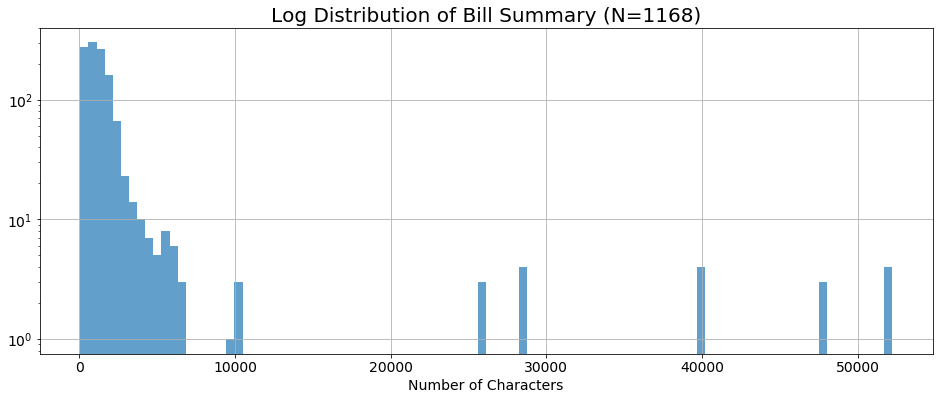

In [292]:
fig, ax = plt.subplots(figsize=(16, 6))
ed_bills_join['summary_length'].hist(bins=100, ax=ax, alpha=0.7);
ax.set_yscale('log'); #ax.set_xlim(xmin=0);
ax.set_xlabel('Number of Characters', size=14);
ax.set_title('Log Distribution of Bill Summary (N={})'.format(len(ed_bills_join)), size=20);

In [1041]:
duplicates = ed_bills_join[ed_bills_join.duplicated('bill_ix')].bill_ix.unique()
duplicates

array([ 5741,  6037,  6324,  6429,  6726,  7372,  7625,  8914,  9041,
       10058, 11782, 12817, 13120, 13715, 13999, 16100, 17276, 18991,
       20269, 21074, 22786, 25291, 27020, 27653, 27886, 28789, 29038,
       29095, 29642, 29671, 29781, 29854, 31214, 32234])

In [1044]:
ix = 7
test_bill = ed_bills_join[(ed_bills_join['summary_length'] > 9000)&(ed_bills_join['bill_ix']==duplicates[ix])].copy()
test_bill

,bill_ix,official_title,bill_type,status_at,sponsor,status,subjects_top_term,bill_id,introduced_at,congress,short_title,summary_text,as,date,code,full_text,summary_length
194,8914,To support State and local accountability for ...,0,2015-07-08,12374,2.0,Education,hr5-114,2015-02-03,114,Student Success Act,Student Success Act\n\n(Sec. 6) Reauthorizes t...,Passed House amended,2015-07-08,PCS,"<?xml-stylesheet type=""text/xsl"" href=""billres...",52203
195,8914,To support State and local accountability for ...,0,2015-07-08,12374,2.0,Education,hr5-114,2015-02-03,114,Student Success Act,Student Success Act\n\n(Sec. 6) Reauthorizes t...,Passed House amended,2015-07-08,IH,"<?xml-stylesheet type=""text/xsl"" href=""billres...",52203
196,8914,To support State and local accountability for ...,0,2015-07-08,12374,2.0,Education,hr5-114,2015-02-03,114,Student Success Act,Student Success Act\n\n(Sec. 6) Reauthorizes t...,Passed House amended,2015-07-08,RH,"<?xml-stylesheet type=""text/xsl"" href=""billres...",52203
197,8914,To support State and local accountability for ...,0,2015-07-08,12374,2.0,Education,hr5-114,2015-02-03,114,Student Success Act,Student Success Act\n\n(Sec. 6) Reauthorizes t...,Passed House amended,2015-07-08,EH,"<?xml-stylesheet type=""text/xsl"" href=""billres...",52203


In [ ]:
full_trees = {}
full_texts = {}
for ix, row in test_bill.iterrows():
    print(row['status_at'], row['introduced_at'], row['as'], row['date'], row['code'], len(row['full_text']))
    tree =  etree.fromstring(row['full_text'])
    full_text = create_single_text_string(tree)
    full_texts[ix] = full_text
    full_trees[ix] = tree

In [1046]:
rank_codes = ['ENR', 'EAS', 'EAH', 'RS', 'ES',
              'PCS', 'EH', 'RH', 'IS', 'IH']
code = next(i for i in rank_codes if i in test_bill['code'].unique())
test_bill = test_bill[test_bill['code'] == code]

In [1047]:
test_bill

,bill_ix,official_title,bill_type,status_at,sponsor,status,subjects_top_term,bill_id,introduced_at,congress,short_title,summary_text,as,date,code,full_text,summary_length
34,6037,To reauthorize the Scholarships for Opportunit...,0,2016-04-29,12405,2.0,Education,hr4901-114,2016-04-12,114,Scholarships for Opportunity and Results Reaut...,(This measure has not been amended since it wa...,Passed House without amendment,2016-04-29,PCS,"<?xml-stylesheet type=""text/xsl"" href=""billres...",5533


In [1081]:
from lxml import etree


In [460]:
def create_single_text_string(tree, tag='text'):
    text = ""
    for elt in tree.getiterator(tag):
        if isinstance(elt.text, str):
            text += elt.text  + ' '
    return text

In [1049]:
from xml.etree.ElementTree import fromstring, ElementTree
import xml.etree.ElementTree as ET

all_tags = []
for elt in tree.getiterator():#('{http://purl.org/dc/elements/1.1/}date'):
    #print(elt.tag, elt.text)
    all_tags.append(elt.tag)

In [1298]:
import random

In [1204]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/melissaferrari/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [1061]:
import string
import spacy

nlp = spacy.load('en_core_web_lg')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [1062]:
test_bill.columns

Index(['bill_ix', 'official_title', 'bill_type', 'status_at', 'sponsor',
       'status', 'subjects_top_term', 'bill_id', 'introduced_at', 'congress',
       'short_title', 'summary_text', 'as', 'date', 'code', 'full_text',
       'summary_length'],
      dtype='object')

In [1063]:
text_dict = test_bill.iloc[0].to_dict()
full_string_xml = text_dict['full_text']
full_tree = etree.fromstring(full_string_xml)

In [1074]:
bill_id, official_title = (text_dict['bill_id'], text_dict['official_title'])
print(bill_id, official_title)

hr4901-114 To reauthorize the Scholarships for Opportunity and Results Act, and for other purposes.


In [1075]:
short_title = text_dict['short_title']
print(short_title)

Scholarships for Opportunity and Results Reauthorization Act


In [1082]:
summ_text = text_dict['summary_text']
#print(summ_text)

In [1083]:
full_text = create_single_text_string(full_tree)

In [520]:
xpathselector = 'section/enum'
hold = full_tree.xpath(xpathselector)

In [1088]:
full_tree = ET.ElementTree(ET.fromstring(full_string_xml))
root = full_tree.getroot()

In [1089]:
for child in root:
    print(child.tag, child.attrib)

metadata {}
form {}
legis-body {'id': 'H089E2AD3E9F4472FA050886A8625AD08', 'style': 'OLC'}
attestation {}
endorsement {}


In [1130]:
all_descendants = list(root.iter())
#for thing in root.findall(".//text"):
#    print(thing.tag, thing.attrib, thing.text)

In [1092]:
all_tags = [elem.tag for elem in root.iter()]

In [1095]:
# VIEW CML
print(ET.tostring(root, encoding='utf8').decode('utf8')[:1000]);

<?xml version='1.0' encoding='utf8'?>
<bill xmlns:dc="http://purl.org/dc/elements/1.1/" bill-stage="Placed-on-Calendar-Senate" bill-type="olc" dms-id="H775D919078204AD69CA1574764D6C19A" public-private="public" stage-count="1">
	<metadata>
<dublinCore>
<dc:title>114 HR 4901 PCS: Scholarships for Opportunity and Results Reauthorization Act</dc:title>
<dc:publisher>U.S. House of Representatives</dc:publisher>
<dc:date />
<dc:format>text/xml</dc:format>
<dc:language>EN</dc:language>
<dc:rights>Pursuant to Title 17 Section 105 of the United States Code, this file is not subject to copyright protection and is in the public domain.</dc:rights>
</dublinCore>
</metadata>
<form>
		<distribution-code display="yes">II</distribution-code>
		<calendar>Calendar No. 564</calendar><congress display="yes">114th CONGRESS</congress>
		<session display="yes">2d Session</session>
		<legis-num>H. R. 4901</legis-num>
		<current-chamber display="yes">IN THE SENATE OF THE UNITED STATES</current-chamber><action>

In [1116]:
ordered_list = []
data = pd.DataFrame()
for ix, description in enumerate(root.iter()):
    if description.text is None:
        # print(description.tag)
        pass
    elif description.text.isspace():
        pass
    #elif description.tag == 'external-xref':
     #   data = data.append([[ix, description.tag, description.text]])
    elif description.tag in ['enum', 'header', 'text']:
        data = data.append([[ix, description.tag, description.text]])
        if description.tag == 'enum':
            ordered_list.append(description.text)
    else:
        pass
        #print(ix, description.tag, description.text)
data = data.reset_index(drop=True)
data.columns = ['sent_ix', 'tag', 'text']

In [1104]:
data.head()

,sent_ix,tag,text
0,29,enum,1.
1,30,header,Short title; references in Act
2,32,enum,(a)
3,33,header,Short Title
4,34,text,This Act may be cited as the


In [1118]:
sentences = []
full_string = ""
astr = ""
for ix, row in data[data.tag != 'header'].iterrows():
    astr += row['text'] + ' '
    full_string += row['text'] + ' '
    if row['tag'] == 'enum':
        #print(row['text'])
        nextix = ix + 1
    if nextix == ix:
        sentences.append(astr)
        astr = ""

In [1119]:
doc = nlp(full_string)
full_sentences = [sent.string.strip() for sent in doc.sents]
len(full_sentences)

120

In [1121]:
for ix in range(len(full_sentences)):
    for x in ordered_list:
        if x in full_sentences[ix]:
            full_sentences[ix] = full_sentences[ix].replace(x, "")
full = []
for sentence in full_sentences:
    if sentence:
        full.append(sentence)
full_sentences = full
len(full_sentences)

87

In [1126]:
df_ent = pd.DataFrame()
for ix, sentence in enumerate(full_sentences):
    doc = nlp(sentence)

    for ent in doc.ents:
        # print(ix, ent.text, ent.start_char, ent.end_char, ent.label_)
        df_ent = df_ent.append([[ix, ent.text, ent.start_char, ent.end_char, ent.label_]], ignore_index=True)
df_ent.columns = ['sentence', 'text', 'start_char', 'end_char', 'label']
df_ent = df_ent[(df_ent.label != 'CARDINAL')& (~df_ent['text'].apply(str.isspace))]

In [1127]:
df_ent.head()

,sentence,text,start_char,end_char,label
0,1,Act an amendment,57,73,LAW
1,1,the Scholarships for Opportunity and Results Act,241,289,ORG
3,2,the Consolidated Appropriations Act,15,50,LAW
4,2,2016,52,56,DATE
7,7,D.C.,0,4,GPE


In [1128]:
low_alpha = list(string.ascii_lowercase)
up_alpha = list(string.ascii_uppercase)
digits = list(string.digits)
white_space = list(string.whitespace)
punctuation = list(string.punctuation)

In [1131]:
def recurse_tree(node):
    for child in node.getchildren():
        if child.tag == 'enum':
            yield node
        for subchild in recurse_tree(child):
            yield subchild

In [1133]:
# returns 
enum_parents =list(recurse_tree(root)) 

In [1139]:
summ_doc = nlp(summ_text)
summ_sentences = [sent.string.strip() for sent in summ_doc.sents]
len(summ_sentences)

34

In [1141]:
full_doc = nlp(full_text)
full_sentences = [sent.string.strip() for sent in full_doc.sents]
len(full_sentences)

70

In [ ]:
full_text = create_single_text_string(tree)
bad_string = "\n\t\t\t"
if bad_string in full_text:
    full_text =full_text.replace(bad_string, "")t

In [1147]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(full_text)
#print(tokenized_word)

In [1148]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)

In [1150]:
fdist.most_common(2)

[('the', 254), ('of', 190)]

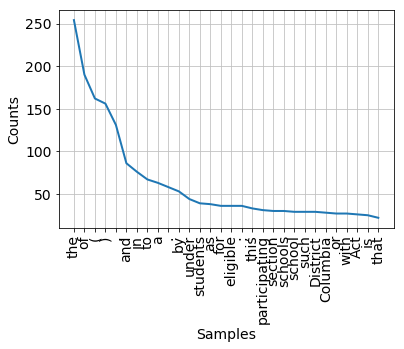

In [1151]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [1160]:
from nltk.corpus import stopwords
stop_words= set(nltk.corpus.stopwords.words("english"))

In [1196]:
def remove_punct_nums(sentences):
    # remove punctuations, numbers and special characters
    regex = re.compile(r"[^a-zA-Z]")
    return [regex.sub(" ", s) for s in sentences]

def make_lowercase(sentences):
    return [s.lower() for s in sentences]

In [1180]:
# function to remove stopwords
def remove_stopwords_sentence(sen, stop_words=set(nltk.corpus.stopwords.words("english"))):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

def remove_stopwords_all(sentences):
    return [remove_stopwords_sentence(s.split()) for s in sentences]

In [1199]:
clean_full = full_sentences
clean_full = remove_punct_nums(clean_full)
clean_full = make_lowercase(clean_full)
clean_full = remove_stopwords_all(clean_full)

In [1236]:
len(full_sentences) == len(clean_full)

True

In [1202]:
#Lexicon Normalization
#performing stemming and Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
stem = PorterStemmer()

In [ ]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(full_text)

In [1217]:
def lemmatize_sentence(sen):
    word_list = [lem.lemmatize(word, "v") for word in nltk.tokenize.word_tokenize(sen)]
    return ' '.join(word for word in word_list)

In [1235]:
def remove_empty_sentece(sentences):
    return [s for s in sentences if s and not s.isspace()]

In [ ]:
ordered_list = []
data = pd.DataFrame()
for ix, description in enumerate(root.iter()):
    if description.text is None:
        # print(description.tag)
        pass
    elif description.text.isspace():
        pass
    #elif description.tag == 'external-xref':
     #   data = data.append([[ix, description.tag, description.text]])
    elif description.tag in ['enum', 'header', 'text']:
        data = data.append([[ix, description.tag, description.text]])
        if description.tag == 'enum':
            ordered_list.append(description.text)
    else:
        pass
        #print(ix, description.tag, description.text)
data = data.reset_index(drop=True)
data.columns = ['sent_ix', 'tag', 'text']

### Embeddings.

In [1228]:
# Extract word vectors
f = open('../nlp_models/glove.6B/glove.6B.300d.txt', encoding='utf-8')
word_embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [1294]:
embedding_size = coefs.shape
embedding_size

(300,)

In [1243]:
len(word_embeddings)

400000

In [1313]:
def calc_embeddings(sen, word_embeddings, embedding_size=None):
    if embedding_size == None:
        embedding_size = random.choice(list(word_embeddings.values())).shape
    if len(sen) != 0:
        vector = sum([word_embeddings.get(w, embedding_size) for w in sen.split()])/(len(sen.split())+0.001)
    else:
        vector = np.zeros(embedding_size)
        #print(vector.shape)
    return vector

In [1316]:
sentence_vectors = [calc_embeddings(s, word_embeddings, embedding_size) for s in clean_full]

In [1356]:
## FOR SIM MATRIX, UNUSED

from sklearn.metrics.pairwise import cosine_similarity
# similarity matrix
sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
veclen = list(embedding_size)[0]
for i in range(len(sentence_vectors)):
    for j in range(len(sentence_vectors)):
        if i != j :
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,veclen), 
                                              sentence_vectors[j].reshape(1,veclen))[0,0]

### Clustering

In [1351]:
from sklearn import cluster, metrics

In [1353]:
num_sentences_sum = 5

In [1358]:
kmeans = cluster.KMeans(n_clusters=num_sentences_sum)
kmeans_output = kmeans.fit(sentence_vectors)

avg = []
for j in range(num_sentences_sum):
    idx = np.where(kmeans.labels_ == j)[0]
    avg.append(np.mean(idx))
    
cluster_centers = kmeans.cluster_centers_
closest, distances = metrics.pairwise_distances_argmin_min(cluster_centers, 
                                                           sentence_vectors)
ordering = sorted(range(num_sentences_sum), key=lambda k: avg[k])

In [1361]:
np.where(kmeans.labels_ == 0)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [1362]:
ordering = sorted(range(num_sentences_sum), key=lambda k: avg[k])

In [1363]:
summary = ' '.join([sentences[closest[idx]] for idx in ordering])

[4, 1, 3, 0, 2]